# Segmentación de clíentes (Olist) mediante analisis RFM

## Introducción

### Objetivos

Este notebook tiene como objetivo princpal buscar que segmentos de  clientes según **Recency**, **Frequency** y **Monetary** generan más valor a la empresa.
Algunos objetivos específicos son:
- Encontrar clientes en riesgo de ser perdidos
- Encontrar clientes leales
- Encontrar debilidades de Olist

### Decisiones respecto al análisis RFM
El análisis RFM se basa en tres principios clave:
- **Recency**: ¿Que tán reciente ha sido la ultima compra del cliente
- **Frequency**: ¿Cuántas veces ha comprado el cliente?
- **Monetary**: ¿Cuánto ha gastado en total el cliente?

**Recency**: Para el caso de recency, se decidió tomar como fecha de referencia 2018/09/03, el día de la última compra válida realizada (`order_purchase_timestamp`) en las órdenes del dataset. Dado que el objetivo es analizar el comportamiento del cliente, se usó la fecha de **compra** de su orden (`order_purchase_timestamp`) en lugar de la fecha de entrega, pues la primera explica mejor el momento en el cual el cliente tuvo la intención de comprar. Entonces se tomó como valor de `recency` la cantidad de días desde la última compra **valida** (`order_status != canceled AND order_status != unavailable`) de un clíente hasta la fecha de referencia.

**Frequency**: Para el caso de frequency, hay dos opciones principales: Frecuencia de consumo por un tiempo determinado (Ejm: Compras/Semana), o el total de veces que se ha comprado en total (frecuencia total acumulada). Para un negocio de EComerce, si se quiere tomar una frecuencia por tiempo determinado esta tendría que ser relativamente larga (Ejm: Compras/Semestre). Pero dado que el dataset solo cubre dos años aproximadamente (Desde mitad de 2016 hasta mitad de 2018), se tomó como valor de `frequency` la cantidad total de compras de un cliente **durante estos dos años**.

**Monetary**: Para el caso de monetary, nuevamente también hay enfoques entre gasto por un tiempo determinado (Ejm: Gasto/Semena) o gasto total acumulado. Por los mismos motivos que se explicaron en `frequency`, se decidió tomar como valor de `monetary` el monto total pagado por un cliente.

Para cada métrica, se le asignará un score (de 1 a 5). El método de segmentación en scores de cada métrica puede ser diferente dependiendo de como estén distribuidos sus datos. En base a estos scores segmentará a los clíentes en distintos grupos. Luego, se realizarán métricas para cada uno de estos.

Como extra, estas métricas fueron creadas mediante los archivos `.sql` ubicados en la carpeta `sql/` (Específicamente los 3 primeros).

## Librerías y carga de datos

Importación de librerías

In [1]:
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

Conexión con base de datos

In [2]:
load_dotenv()


user=os.getenv('DB_USER')
password=os.getenv('DB_PASSWORD')
host=os.getenv('DB_HOST')
port=os.getenv('DB_PORT')
db=os.getenv('DB_NAME')

url_conexion=f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}"


engine=create_engine(url_conexion)

Carga de base de datos

In [3]:
query="""
SELECT * FROM customer_rfm
"""

customers_data=pd.read_sql(query, engine)

## Segmentación y creación de *scores* 

Antes de empezar a crear los scores, es importante revisarlos para notar su comportamiento, y aplicar el método de segmentación más conveniente para cada uno.

### Recency_score

<Axes: xlabel='recency', ylabel='Count'>

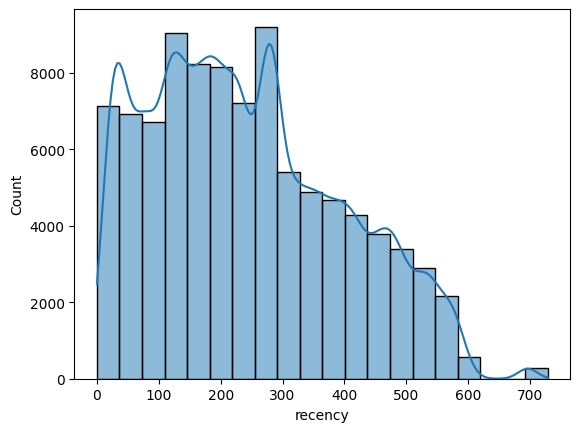

In [27]:
sns.histplot(data=customers_data, x='recency',bins=20,kde= True)

En la gráfica, se puede notar como los datos están sesgados hacia la derecha, un indicativo positivo pues resalta que hay mayoritariamente clientes recientes/nuevos. También, se ve la presencia de un/unos outlier/s al rededor de 750/800.  
El pico de órdenes que hay en 300 se debe muy probablemente a la festividad de *Black Friday*, la cual fue hace apróximadamente 300 días desde la fecha de referencia. Este detalle tomará relevancia en el siguiente *notebook*.  
Inicialmente se tenía previso usar quintiles para la división en los 5 scores, pero esto provocaba tener en un mismo grupo a compradores de hace 0 días como a compradores de hace 100 días (3 meses), por lo qué la mejor decisión es categorizar manualmente los scores.

In [30]:
customers_data['R_score']=customers_data['recency'].apply(lambda x: 1 if x >360 else (2 if x >180 else (3 if x > 90  else (4 if x > 30 else 5))))

In [7]:
n=5
customers_data['R_score']=pd.qcut(customers_data['recency'],5,labels=[x for x in range(5,0,-1)])

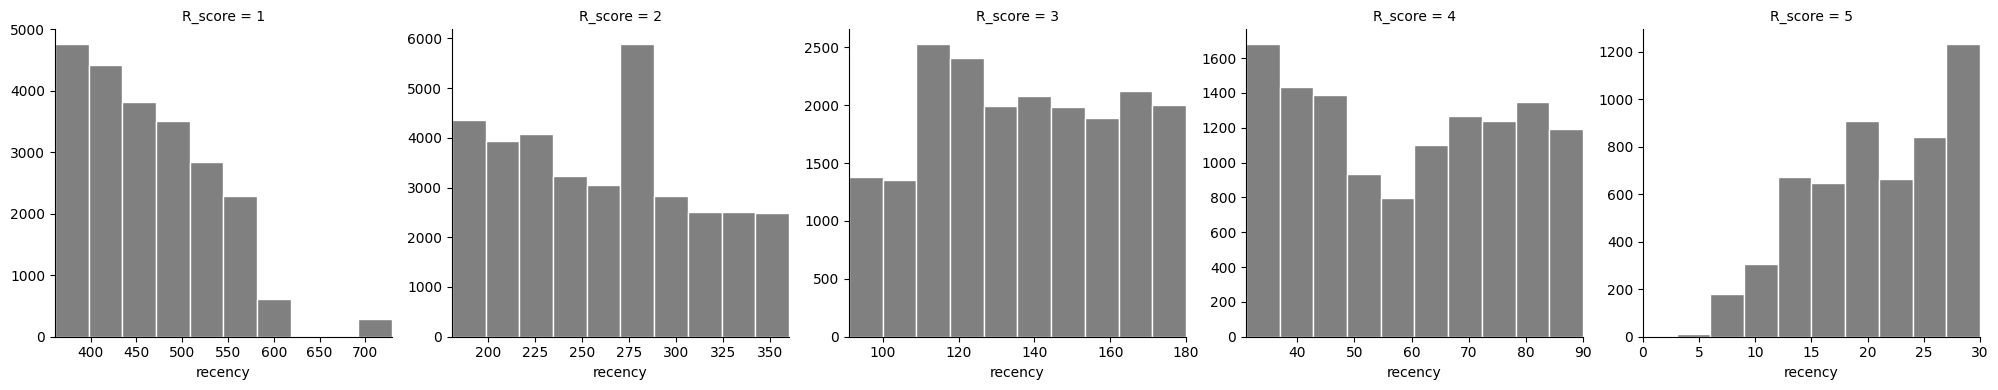

In [31]:
g=sns.FacetGrid(customers_data, col="R_score", sharey=False, sharex=False, height=4)
g.map(plt.hist, "recency", bins=10, color='gray', edgecolor='white')


for ax in g.axes.flat:
    ax.margins(x=0)

plt.show()  

<Axes: xlabel='R_score', ylabel='count'>

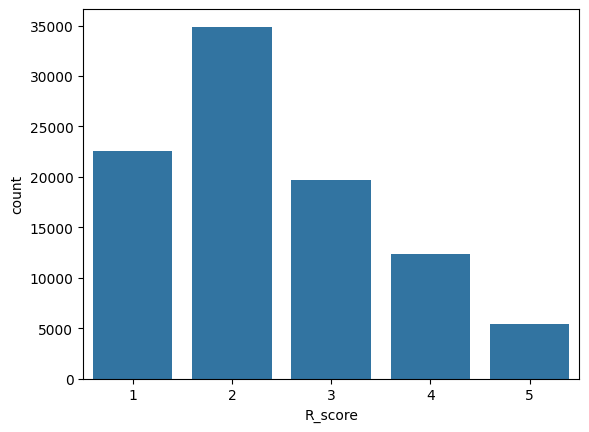

In [33]:
sns.countplot(data = customers_data,x = 'R_score')

### Frequency_score

<Axes: xlabel='frequency', ylabel='count'>

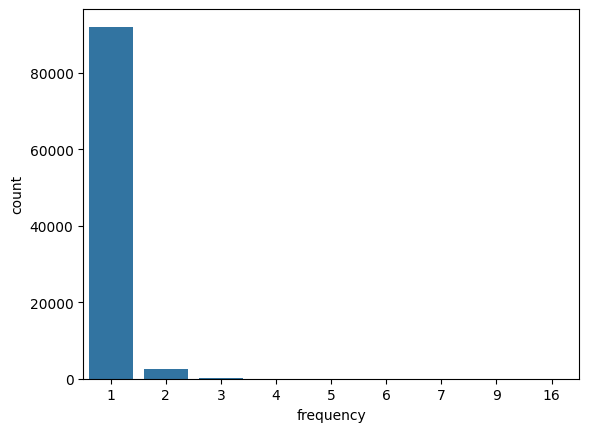

In [34]:
sns.countplot(data=customers_data, x='frequency')

In [35]:
customers_data['frequency'].value_counts()

frequency
1     92101
2      2652
3       188
4        29
5         9
6         5
7         3
9         1
16        1
Name: count, dtype: int64

Frequency es un caso especial, pues tiene una cantidad masiva de personas que solo compraron una vez (el 96.95%). Asignar quintiles provocaría que los scores de 1,2,3 y 4 sean de clientes con una sola compra. Para este caso, lo mejor es asignar manualmente los scores.

Idealmente los scores más bajos(1 y 2) deberían ser asignados a personas con sólo una compra. Luego, personas que hayan comprado dos veces podrían considerarse en un score intermedio (3), y los scores más altos (4 y 5) pueden ser aquellos que compraron 3 y más de 3 veces respectivamente.
|F_score|Intervalo|
|---|---|
|1| frequency=1|
|3| frequency=2|
|4| frequency=3|
|5| frequency > 3|

Para este caso no usaremos el score 2, pues no afecta el análisis.

In [36]:
customers_data['F_score']=customers_data['frequency'].apply(lambda x: 1 if x == 1 else (3 if x == 2 else (4 if x==3 else 5)))

In [37]:
customers_data['F_score'].value_counts()

F_score
1    92101
3     2652
4      188
5       48
Name: count, dtype: int64

## Monetary

<Axes: xlabel='monetary', ylabel='Count'>

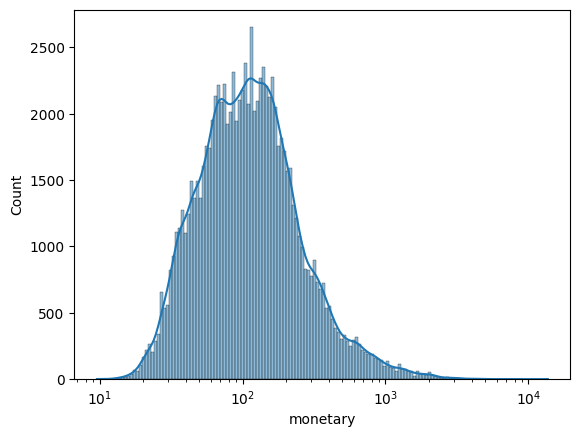

In [38]:
sns.histplot(data=customers_data, x='monetary',log_scale= True, bins=150, kde = True)

Realizando la gráfica en escala logarítmica, se ve que es altísimamente sesgada a la derecha (es normal que hayan compras masivas por parte de uno o dos clientes en un ecomerce). 

In [39]:
customers_data.sort_values(by='monetary',ascending=False)

,customer_unique_id,recency,frequency,monetary,R_score,F_score
49343,0a0a92112bd4c708ca5fde585afaa872,339,1,13664.08,2,1
88024,da122df9eeddfedc1dc1f5349a1a690c,520,2,7571.63,1,3
69524,763c8b1c9c68a0229c42c9fc6f662b93,50,1,7274.88,4,1
88450,dc4802a71eae9be1dd28f5d788ceb526,568,1,6929.31,1,1
60388,459bef486812aa25204be022145caa62,40,1,6922.21,4,1
...,...,...,...,...,...,...
55028,2878e5b88167faab17d4fb83a986d38b,309,1,11.63,2,1
20592,6f5b9d1cdccc4d28f0483a612edecacf,366,1,11.63,1,1
33300,b33336f46234b24a613ad9064d13106d,74,1,10.89,4,1
82546,bd06ce0e06ad77a7f681f1a4960a3cc6,355,1,10.07,2,1


<Axes: xlabel='monetary', ylabel='Count'>

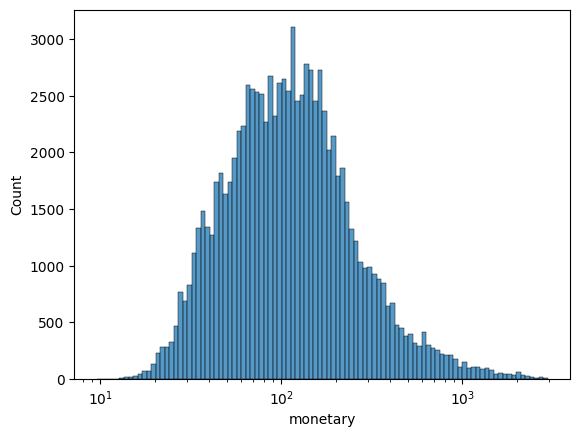

In [40]:
sns.histplot(data=customers_data[customers_data['monetary'] < 3000].copy(), x='monetary',bins=100, log_scale=True)

In [41]:
customers_data['monetary'].agg(['min', 'max', 'count', 'mean','median'])

min           9.590000
max       13664.080000
count     94989.000000
mean        165.694312
median      107.900000
Name: monetary, dtype: float64

Como vemos, la información es altamente asimétrica hacia la derecha. De todas formas, los outliers no suelen afectar mucho el uso de cuantiles para segmentar esta información.

In [42]:
n=5
customers_data['M_score']=pd.qcut(customers_data['monetary'],n,labels=[x for x in range(1,n+1)])

In [43]:
customers_data.groupby('M_score')['monetary'].agg(['min', 'max', 'count', 'mean','median']).sort_index(ascending=False)

,min,max,count,mean,median
M_score,,,,,
5,209.15,13664.08,18996,443.883217,318.97
4,133.06,209.12,19000,165.542564,163.28
3,87.52,133.05,18994,108.700735,107.92
2,55.37,87.51,18998,70.640398,70.03
1,9.59,55.36,19001,39.741837,40.13


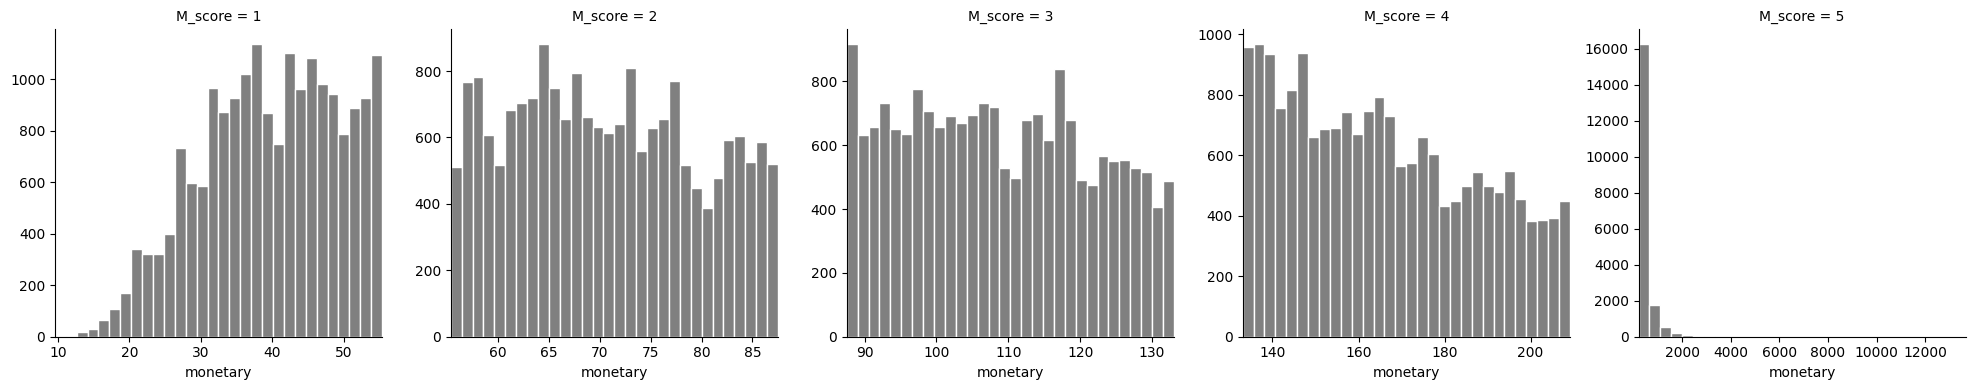

In [44]:
g=sns.FacetGrid(customers_data, col="M_score", sharey=False, sharex=False, height=4)
g.map(plt.hist, "monetary", bins=30, color='gray', edgecolor='white')


for ax in g.axes.flat:
    ax.margins(x=0)

plt.show()

Se muestra como los M_score centrales no parecen estar sesgados, mientras que los score de 1 y 2 están sesgados a la izquierda y derecha respectivamente.

## Análisis multivariado entre R, F y M

<Axes: >

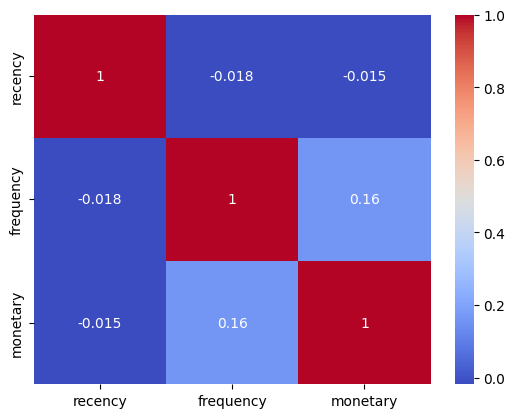

In [45]:
cor=customers_data[['recency','frequency','monetary']].corr(method='spearman')
sns.heatmap(cor, annot=True, cmap='coolwarm')

Como vemos, las correlaciones entre las variables son bajas, lo que nos indica que no son redundantes entre sí, y cada métrica captura un comportamiento distinto del cliente

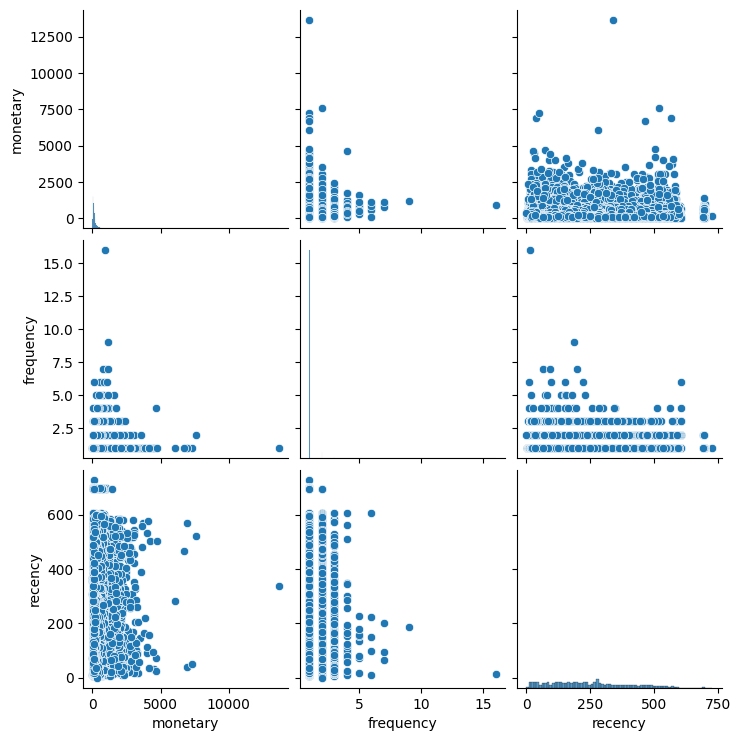

In [46]:
sns.pairplot(customers_data[['monetary','frequency','recency']])

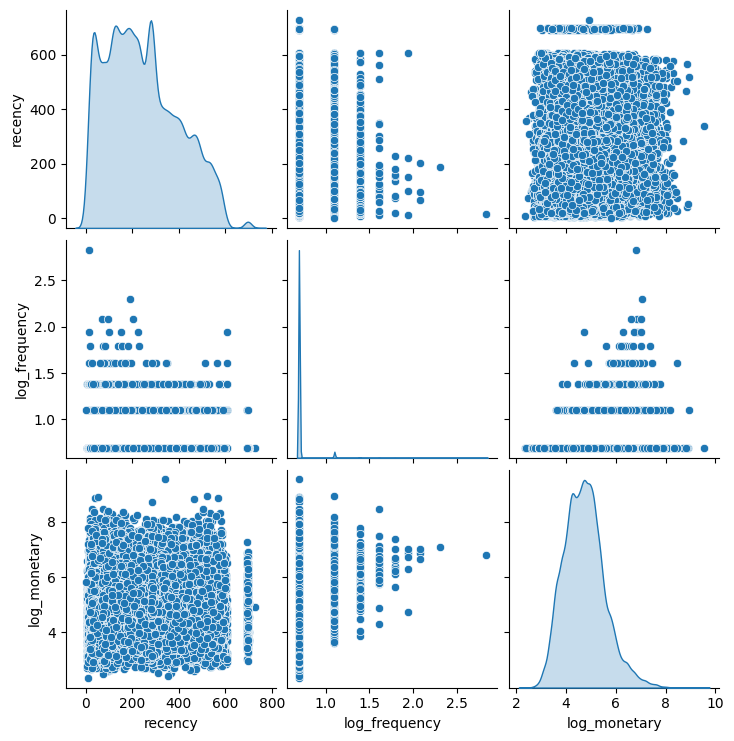

In [47]:
# Creamos una versión "log" para visualizar
rfm_log=customers_data[['recency', 'frequency', 'monetary']].copy()
rfm_log['log_frequency']=np.log1p(rfm_log['frequency']) # log(1+x) para evitar log(0)
rfm_log['log_monetary']=np.log1p(rfm_log['monetary'])

sns.pairplot(rfm_log[['recency', 'log_frequency', 'log_monetary']], diag_kind='kde')

In [48]:
# Definimos el tamaño total de la muestra para que Plotly sea fluido
total_sample=15000 
frac=total_sample / len(customers_data)

# Muestreo estratificado por la combinación de los 3 scores
customers_data_sampled=customers_data.groupby('rfm_cell', group_keys=False).apply(
    lambda x: x.sample(frac=frac, random_state=42) if len(x) > 5 else x
)

# Clientes comunes (baja frecuencia)
common_mask=customers_data['F_score'] == 1
# Clientes interesantes (mayor frecuencia o alto gasto)
valuable_mask=customers_data['F_score'] > 1

# Muestreamos solo a los comunes, mantenemos a todos los valiosos
df_viz=pd.concat([
    customers_data[common_mask].sample(frac=0.05, random_state=42),
    customers_data[valuable_mask]
])

# Añadimos un pequeño ruido (jitter) de +- 0.2 para dispersar los puntos
customers_data_viz=customers_data_sampled.copy()
for col in ['R_score', 'F_score', 'M_score']:
    customers_data_viz[col]=customers_data_viz[col].astype(float) + np.random.uniform(-0.2, 0.2, size=len(customers_data_viz))


KeyError: 'rfm_cell'

### Analizando Recency y Monetary

<function matplotlib.pyplot.show(close=None, block=None)>

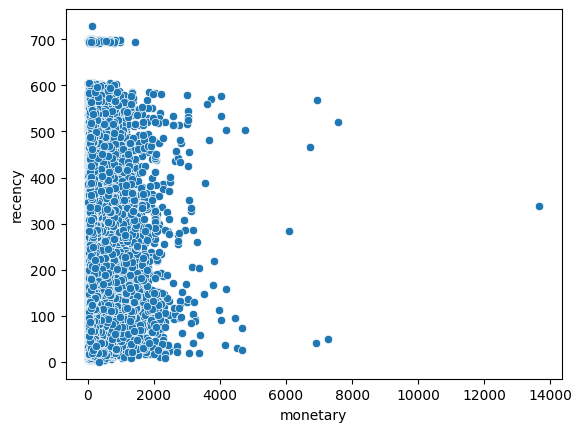

In [49]:
g=sns.scatterplot(data=customers_data, x='monetary', y='recency')
plt.show

### Frequency y Monetary

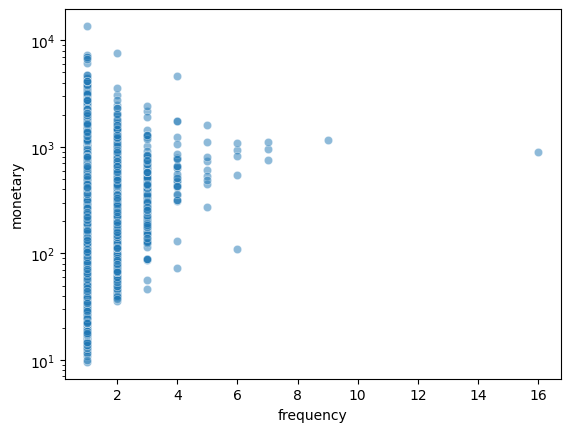

In [50]:
g=sns.scatterplot(data=customers_data ,x='frequency',y='monetary',alpha=0.5)
g.set(yscale='log')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

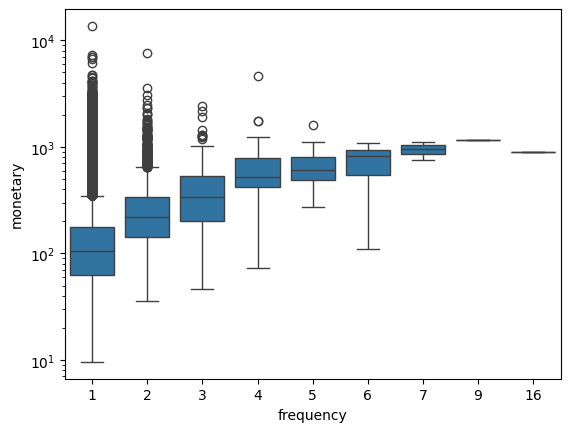

In [51]:
g=sns.boxplot(data=customers_data,x='frequency',y='monetary')
#g=sns.boxplot(data=customers_data[customers_data['monetary'] < 12000],x='frequency',y='monetary')
g.set(yscale='log')
plt.show

Se ve como mientras más haya comprado un cliente, mayor es su valor, lo cual es obvio pero no es tan directo como se cree, pues se logran ver bastantes outliers con bajos valores de frequency.

### Recency y Frequency

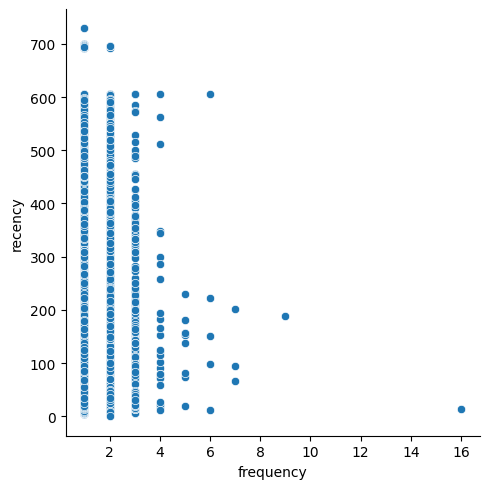

In [52]:
sns.relplot(data=customers_data,x='frequency',y='recency',kind='scatter')

<Axes: xlabel='frequency', ylabel='recency'>

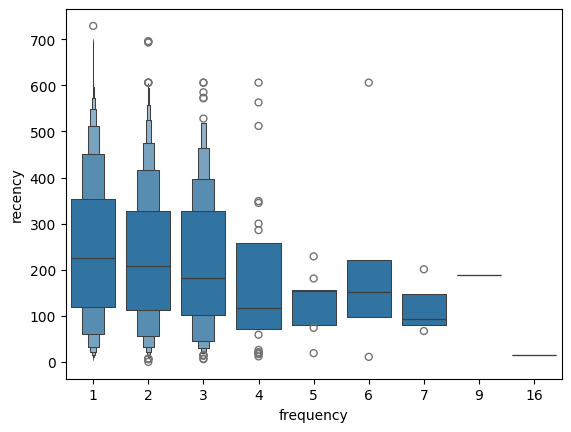

In [53]:
sns.boxenplot(data=customers_data,x='frequency',y='recency',)

Como se ve, si bien a mayor frecuencia más reciente suele ser un cliente, hay varios clientes que son bastante recientes y solo han comprado una vez, esto indica que son clientes **nuevos**, mientras que los que son más lejanos son ya clientes perdidos.

### Detección de outliers multivariantes


In [54]:
from sklearn.ensemble import IsolationForest

iso=IsolationForest(contamination=0.01, random_state=42)
customers_data['multivariate_outlier']=iso.fit_predict(customers_data[['recency', 'frequency', 'monetary']])
outliers=customers_data[customers_data['multivariate_outlier'] == -1]
normals=customers_data[customers_data['multivariate_outlier'] == 1]

In [55]:
print(len(outliers))
comparativa=pd.DataFrame({
    'Outliers_Mean': outliers[['recency', 'frequency', 'monetary']].mean(),
    'Normal_Mean': normals[['recency', 'frequency', 'monetary']].mean(),
    'Outliers_Max': outliers[['recency', 'frequency', 'monetary']].max(),
    'Normal_Max': normals[['recency', 'frequency', 'monetary']].max()
})
print(comparativa)

950
           Outliers_Mean  Normal_Mean  Outliers_Max  Normal_Max
recency       257.886316   243.197578        699.00      729.00
frequency       1.732632     1.026808         16.00        3.00
monetary     1452.828758   152.691433      13664.08     1564.07


## Segmentación - Score final


Ahora sí, se pasará a la segmentación final usando estos criterios

|Segmento|Descripción|Lógica|
| --- | --- |---|
|Champions|Compraron recientemente, son frecuentes y gastan bastante|R∈{4,5},F∈{4,5},M∈{4,5}|
|Loyal/Active| Compraron recientemente y son frecuentes | R∈{4,5}, F=5 |
|Potential Loyalists| Compraron recientemente y ya compraron más de una vez | R∈{4,5}, F∈{3,4}|
|Loyal at risk |Eran frecuentes y generaron bastante dinero pero hace tiempo que compran |R∈{1,2}, F∈{3,4,5}, M∈{3,4,5} |
|Need atention|Compraron hace tiempo, tienen 2 compras| R∈{2,3}, F=3 
|About to sleep| Compraron una vez hace un tiempo y están a punto de perderse| R=3, F=1|
|New customers| Acaban de comprar, solo van una vez| R∈{4,5}, F=1|
|Big Spenders One Time| Compraron una vez pero generaron bastante | F=1, M∈{4,5} |
|Lost| Compraron una vez y nunca volvieron | R∈{1,2}, F=1|


In [56]:
def segmentar_cliente(row):
    r = row['R_score']
    f = row['F_score']
    m = row['M_score']
    
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    
    elif r >= 4 and f == 5:
        return 'Loyal/Active'
        
    elif r >= 4 and f >= 3:
        return 'Potential Loyalists'
    
    elif r <= 2 and f >= 3 and m >= 3:
        return 'Loyal at risk'
        
    elif (r == 2 or r == 3) and f == 3:
        return 'Need attention'
    

    elif f == 1 and m >= 4:
        return 'Big Spenders One Time'
        
    elif r >= 4 and f == 1:
        return 'New customers'
        
    elif r == 3 and f == 1:
        return 'About to sleep'
        
    elif r <= 2 and f == 1:
        return 'Lost'
    
    else:
        return 'Others / General'

customers_data['segment'] = customers_data.apply(segmentar_cliente, axis=1)


In [57]:
print(customers_data['segment'].value_counts(normalize=True) * 100)

segment
Big Spenders One Time    37.583299
Lost                     36.331575
About to sleep           12.009812
New customers            11.034962
Loyal at risk             1.632821
Need attention            0.653760
Potential Loyalists       0.567434
Others / General          0.128436
Champions                 0.057901
Name: proportion, dtype: float64


In [58]:
segment_analysis = customers_data.groupby('segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'sum', 'count']
}).round(2)

segment_analysis

recency frequency monetary                    
                         mean      mean     mean          sum  count
segment                                                             
About to sleep         136.95      1.00    73.30    836165.16  11408
Big Spenders One Time  240.99      1.00   300.98  10744944.08  35700
Champions               46.42      3.69   627.47     34511.00     55
Lost                   342.06      1.00    72.56   2504025.44  34511
Loyal at risk          321.59      2.09   315.66    489583.63   1551
Need attention         147.07      2.00   279.32    173456.92    621
New customers           46.83      1.00    72.84    763468.21  10482
Others / General       289.26      2.79   300.27     36632.97    122
Potential Loyalists     47.93      2.01   290.07    156349.60    539

In [ ]:
        customers_data['rfm_cell']=(customers_data['R_score'].astype(str) + 
                    customers_data['F_score'].astype(str) + 
                    customers_data['M_score'].astype(str))

In [60]:
import plotly.express as px

fig=px.scatter_3d(customers_data_viz,
                    x= 'R_score',
                    y= 'F_score',
                    z='M_score',
                    color='segment',
                    opacity=0.7)

fig.update_layout(margin=dict(l=0,r=0,b=0,t=40))

fig.show()

NameError: name 'customers_data_viz' is not defined